# Project 1 — Notebook 1: Data Wrangling and EDA

**Data Sources:**
- [CDC NHANES 1999–2000](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=1999) — Demographic and dietary survey data
- [CDC Linked Mortality File (LMF)](https://www.cdc.gov/nchs/data-linkage/mortality-public.htm) — Mortality follow-up through December 31, 2019

**Goal of this notebook (Part 1 — 40 pts):** Load, merge, and clean the data; describe key variables; select and justify features; document missing values; and conduct thorough EDA and visualization.

>> **AI Assistance Disclosure:** Portions of this notebook were generated with AI assistance (Claude), (ChatGPT 5.2 Pro),(Cursor). All code has been reviewed, tested, and is understood by the authors. Where AI-suggested code goes beyond the course material, a comment explains why it was used. Per course policy, AI use is cited where it occurred. AI assisted in structure and formatting as well


## 1. Imports and Setup

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 100

# Path configuration
# Set DATA_DIR to the folder containing your three data files:
#   linked_mortality_file_1999_2000.csv
#   DEMO.xpt
#   DRXTOT.xpt
import os
DATA_DIR  = '.'   # <-- change this if your files are elsewhere
LMF_PATH  = os.path.join(DATA_DIR, 'linked_mortality_file_1999_2000.csv')
DEMO_PATH = os.path.join(DATA_DIR, 'DEMO.xpt')
DIET_PATH = os.path.join(DATA_DIR, 'DRXTOT.xpt')


## 2. Loading and Merging the Data

We work with three files merged on `SEQN`, the unique participant identifier shared across all NHANES and LMF files:

| File | Description |
|---|---|
| `linked_mortality_file_1999_2000.csv` | Pre-cleaned CDC Linked Mortality File. Contains vital status and follow-up time through December 31, 2019 for NHANES participants. |
| `DEMO.xpt` | NHANES 1999–2000 Demographics file. Contains age, sex, race/ethnicity, education, income, household composition, and marital status. |
| `DRXTOT.xpt` | NHANES 1999–2000 Dietary Recall Totals. Contains 24-hour dietary intake totals including calories, macronutrients, alcohol, caffeine, and fiber. |

We use inner joins so only participants present in all three files are retained. This is appropriate because we need both predictor data and an outcome for every observation in our analysis.

In [4]:
# Load mortality file
mdf = pd.read_csv(LMF_PATH)
print(f'LMF shape: {mdf.shape}')
print(mdf.head(3))

# Load demographics file
gdf = pd.read_sas(DEMO_PATH, format='xport')
print(f'\nDEMO shape: {gdf.shape}')
print(gdf.head(3))

LMF shape: (9965, 8)
   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  

DEMO shape: (9965, 144)
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   

   RIDRETH1  RIDRETH2  ...      WTIREP43      WTIREP44      WTIREP45  \
0       4.0       2.0  ...  10094.017100   9912.461855   9727.078709   
1       3.0       1.0  ...  27186.728682  27324.345051  28099.663528   
2       3.0       1.0  ...  43993.193099

In [26]:
# Merge mortality and demographics on SEQN
df = gdf.merge(mdf, on='SEQN', how='inner')
print("Merged shape:", df.shape)
print("Rows lost after merge:", len(gdf) - len(df))

Merged shape: (9965, 151)
Rows lost after merge: 0


In [ ]:
print("ELIGSTAT distribution before filtering:")
print(df["ELIGSTAT"].value_counts(dropna=False))

df = df[df["ELIGSTAT"] == 1].copy()

print("\nShape after filtering to ELIGSTAT == 1:", df.shape)

ELIGSTAT distribution before filtering:
ELIGSTAT
1    5445
2    4517
3       3
Name: count, dtype: int64

Shape after filtering to ELIGSTAT == 1: (5445, 151)


### Filtering to Mortality Linkage Eligible Participants

The CDC Linked Mortality File documentation specifies that only participants with ELIGSTAT = 1 are eligible for public mortality linkage. Individuals with ELIGSTAT values of 2 or 3 either were under age 18 or lacked sufficient identifying information and therefore have missing mortality outcomes.

To ensure valid mortality classification and follow-up time analysis, we restrict the dataset to participants with ELIGSTAT equal to 1.

This prevents structural missingness from biasing mortality modeling

In [31]:
# Load dietary recall file and select columns of interest
hdf = pd.read_sas(DIET_PATH)

DIET_COLS = [
    'SEQN',
    'DRXTKCAL',  # Total kilocalories
    'DRXTPROT',  # Total protein (g)
    'DRXTCARB',  # Total carbohydrates (g)
    'DRXTTFAT',  # Total fat (g)
    'DRXTCHOL',  # Total dietary cholesterol (mg)
    'DRXTFIBE',  # Total dietary fiber (g)
    'DRXTCAFF',  # Total caffeine (mg)
    'DRXTALCO',  # Total alcohol (g)
]
filtered_hdf = hdf[DIET_COLS]
print(f'Dietary (filtered) shape: {filtered_hdf.shape}')
print(filtered_hdf.head(3))

Dietary (filtered) shape: (9282, 9)
   SEQN  DRXTKCAL  DRXTPROT  DRXTCARB  DRXTTFAT  DRXTCHOL  DRXTFIBE  \
0   1.0   1358.88     31.96    250.36     27.24     46.55      7.41   
1   2.0   2463.00    123.16    350.37     71.95    313.95     36.99   
2   3.0   1517.69     40.19    233.63     49.94     86.22     11.16   

       DRXTCAFF      DRXTALCO  
0  5.397605e-79  5.397605e-79  
1  5.304500e+02  5.397605e-79  
2  3.540000e+01  5.397605e-79  


### Merging Dietary Data

Not everyone completed the 24-hour dietary recall. We use a left join so we keep all mortality-eligible participants and let the dietary variables be missing where needed. This way we don’t accidentally shrink our sample before modeling.

In [32]:
# Merge dietary data with the already-merged DEMO + LMF dataframe
df = df.merge(filtered_hdf, on="SEQN", how="left")
print(f'Final merged shape: {df.shape}')
df.head(3)

Final merged shape: (4973, 175)


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,DRXTCAFF_y,DRXTALCO_y,DRXTKCAL,DRXTPROT,DRXTCARB,DRXTTFAT,DRXTCHOL,DRXTFIBE,DRXTCAFF,DRXTALCO
0,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,5.304500e+02,5.397605e-79,2463.00,123.16,350.37,71.95,313.95,36.99,5.304500e+02,5.397605e-79
1,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,5.397605e-79,3.456000e+01,2658.14,97.13,253.98,114.52,180.57,17.28,5.397605e-79,3.456000e+01
2,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,2.672300e+02,5.397605e-79,1113.66,24.63,202.11,25.15,38.45,6.24,2.672300e+02,5.397605e-79


## 3. Key Variable Descriptions (5 pts)

Four variables from the CDC Linked Mortality File are central to this project. Their definitions come from the [LMF public-use documentation](https://www.cdc.gov/nchs/data-linkage/mortality-public.htm) and the associated SAS codebook.

---

### `ELIGSTAT` — Linkage Eligibility Status

Indicates whether a survey participant was eligible for mortality record linkage to the National Death Index (NDI).

| Value | Meaning |
|---|---|
| 1 | Eligible adult (age 18+) with sufficient identifying data |
| 2 | Under age 18 — not eligible for public-use mortality release |
| 3 | Not eligible due to insufficient identifying data |

Only participants with `ELIGSTAT = 1` have valid mortality data. All others have missing values for `MORTSTAT`, `PERMTH_INT`, and related variables. This is the first filter we apply before any analysis.

---

### `MORTSTAT` — Vital Status

The primary outcome for our **classification** task.

| Value | Meaning |
|---|---|
| 0 | Assumed alive as of December 31, 2019 |
| 1 | Assumed deceased (linked to a death certificate in the NDI) |
| Missing | Participant was not linkage-eligible (`ELIGSTAT ≠ 1`) |

Vital status is determined by probabilistic record linkage — participants who matched NDI records are assumed deceased; those who did not are assumed alive. A small fraction of status assignments may be in error due to the probabilistic nature of linkage.

---

### `PERMTH_INT` — Person-Months of Follow-up from Interview Date

The primary outcome for our **regression** task.

This variable records the number of person-months elapsed from the participant's interview date to either:
- Their date of death (if `MORTSTAT = 1`), or
- December 31, 2019 — the end of the mortality follow-up window (if `MORTSTAT = 0`).

For the 1999–2000 cohort, the maximum possible follow-up is approximately 240 months (20 years). Participants with values near 240 are censored — they were alive at the end of the study window and may have died later. This censoring is an important limitation for regression modeling.

---

### `RIDAGEEX` — Age at Examination (in months)

From the NHANES DEMO file. Records the participant's exact age at their medical examination in **months**. Dividing by 12 gives a precise age in years. This is preferred over `RIDAGEYR` (which is topcoded at 85 years to protect privacy of elderly participants). Age is expected to be the single strongest predictor of both `MORTSTAT` and `PERMTH_INT`.

In [33]:
print('─' * 50)
print('ELIGSTAT — Linkage Eligibility')
print('─' * 50)
eligstat_counts = df['ELIGSTAT'].value_counts().rename({
    1: 'Eligible adult (18+)',
    2: 'Under 18',
    3: 'Insufficient identifying data'
})
print(eligstat_counts)

print('\n' + '─' * 50)
print('MORTSTAT — Vital Status (eligible adults only)')
print('─' * 50)
eligible = df[df['ELIGSTAT'] == 1]
mortstat_counts = eligible['MORTSTAT'].value_counts().rename({0.0: 'Assumed alive', 1.0: 'Assumed deceased'})
print(mortstat_counts)
print(f'Mortality rate: {eligible["MORTSTAT"].mean()*100:.1f}%')

print('\n' + '─' * 50)
print('PERMTH_INT — Person-Months Follow-up (eligible adults only)')
print('─' * 50)
print(eligible['PERMTH_INT'].describe().round(2))

print('\n' + '─' * 50)
print('RIDAGEEX / 12 — Age at Exam in Years (eligible adults only)')
print('─' * 50)
print((eligible['RIDAGEEX'] / 12).describe().round(2))

──────────────────────────────────────────────────
ELIGSTAT — Linkage Eligibility
──────────────────────────────────────────────────
ELIGSTAT
Eligible adult (18+)    4973
Name: count, dtype: int64

──────────────────────────────────────────────────
MORTSTAT — Vital Status (eligible adults only)
──────────────────────────────────────────────────
MORTSTAT
Assumed alive       3519
Assumed deceased    1454
Name: count, dtype: int64
Mortality rate: 29.2%

──────────────────────────────────────────────────
PERMTH_INT — Person-Months Follow-up (eligible adults only)
──────────────────────────────────────────────────
count    4973.00
mean      205.68
std        63.75
min         1.00
25%       208.00
50%       235.00
75%       243.00
max       250.00
Name: PERMTH_INT, dtype: float64

──────────────────────────────────────────────────
RIDAGEEX / 12 — Age at Exam in Years (eligible adults only)
──────────────────────────────────────────────────
count    4840.00
mean       46.13
std        19.62


## 4. Filtering to Analysis Sample and Feature Selection (5 pts)

### 4.1 Filter to Linkage-Eligible Adults

We restrict to `ELIGSTAT = 1` (adults 18+ with sufficient identifying data). The 4,517 under-18 participants and 3 ineligible-data participants are excluded because they have no mortality outcomes. We then convert `RIDAGEEX` from months to years.

In [34]:
# Filter to linkage-eligible adults
eligible = df[df['ELIGSTAT'] == 1].copy()

# Convert age from months to years for interpretability
eligible['AGE_YRS'] = eligible['RIDAGEEX'] / 12

print(f'Eligible adults: {len(eligible):,}')
print(f'Deceased (MORTSTAT=1): {int(eligible["MORTSTAT"].sum()):,} ({eligible["MORTSTAT"].mean()*100:.1f}%)')
print(f'Assumed alive (MORTSTAT=0): {int((eligible["MORTSTAT"]==0).sum()):,}')

Eligible adults: 4,973
Deceased (MORTSTAT=1): 1,454 (29.2%)
Assumed alive (MORTSTAT=0): 3,519


### 4.2 Variable Selection and Rationale

We draw predictors from two NHANES modules: **DEMO** (demographics) and **DRXTOT** (dietary intake). The selection is guided by established epidemiological literature on predictors of all-cause mortality.

#### Demographic Variables (from DEMO.xpt)

| Variable | Label | Rationale |
|---|---|---|
| `AGE_YRS` | Age at exam (years) | The single strongest known predictor of mortality. Biological aging drives nearly all-cause death risk. |
| `RIAGENDR` | Sex | Men have consistently higher age-adjusted mortality than women across almost all causes of death. |
| `RIDRETH1` | Race/ethnicity | Captures downstream effects of structural racism, differential healthcare access, and genetic risk variation. |
| `INDFMPIR` | Family income-to-poverty ratio | Socioeconomic status is one of the most robust predictors of mortality in the US, independent of other factors. |
| `DMDEDUC` | Education level | Higher education predicts healthier behaviors, better healthcare utilization, and lower mortality. |
| `DMDMARTL` | Marital status | Married individuals consistently show lower mortality, attributed to social support, shared resources, and health monitoring. |
| `DMDHHSIZ` | Household size | Proxy for household social support. Larger households may buffer against isolation, though the direction is nuanced. |

#### Dietary Variables (from DRXTOT.xpt — 24-hour dietary recall)

| Variable | Label | Rationale |
|---|---|---|
| `DRXTKCAL` | Total calories (kcal) | Both extreme under- and over-nutrition are associated with elevated mortality. Captures overall energy balance. |
| `DRXTPROT` | Total protein (g) | Higher protein intake is associated with muscle mass preservation and longevity, especially in older adults. |
| `DRXTCARB` | Total carbohydrates (g) | Excess refined carbohydrate intake is linked to metabolic disease and cardiovascular mortality. |
| `DRXTTFAT` | Total fat (g) | Dietary fat intake type and quantity affect cardiovascular risk. Total fat is included as a summary measure. |
| `DRXTCHOL` | Dietary cholesterol (mg) | Historically associated with cardiovascular disease risk, though evidence is mixed for dietary vs. serum cholesterol. |
| `DRXTFIBE` | Dietary fiber (g) | One of the most consistently protective dietary factors — high fiber intake is associated with reduced all-cause and CVD mortality. |
| `DRXTCAFF` | Caffeine (mg) | Moderate caffeine intake has been associated with reduced mortality in some cohort studies; heavy intake may be a marker of other behaviors. |
| `DRXTALCO` | Alcohol (g) | Heavy alcohol consumption is a major preventable cause of mortality. Captures both protective (moderate) and harmful (heavy) effects. |

In [10]:
# Define feature and target columns
FEATURE_COLS = [
    # Demographic
    'AGE_YRS', 'RIAGENDR', 'RIDRETH1', 'INDFMPIR',
    'DMDEDUC', 'DMDMARTL', 'DMDHHSIZ',
    # Dietary
    'DRXTKCAL', 'DRXTPROT', 'DRXTCARB', 'DRXTTFAT',
    'DRXTCHOL', 'DRXTFIBE', 'DRXTCAFF', 'DRXTALCO'
]

TARGET_CLASS = 'MORTSTAT'
TARGET_REG   = 'PERMTH_INT'

# Complete-case analysis: drop rows with any missing values in selected columns
model_df = eligible[FEATURE_COLS + [TARGET_CLASS, TARGET_REG]].dropna()

print(f'Eligible adults:         {len(eligible):,}')
print(f'Complete cases (no NaN): {len(model_df):,}')
print(f'Dropped (missing data):  {len(eligible) - len(model_df):,}')
print(f'\nMortality rate in analysis sample: {model_df[TARGET_CLASS].mean()*100:.1f}%')

Eligible adults:         4,973
Complete cases (no NaN): 3,574
Dropped (missing data):  1,399

Mortality rate in analysis sample: 26.9%


### 4.3 Missing Data Documentation

We perform a **complete-case analysis**, dropping any row with a missing value in our selected features or outcomes. The table and chart below show the extent of missingness among eligible adults before dropping.

The primary sources of missingness are:
- **`INDFMPIR`** (~26%): Income-to-poverty ratio is frequently missing for low-income households that decline to report income, introducing potential selection bias.
- **`DMDMARTL`** (~23%): Marital status was not collected for participants under 20.
- **`DMDEDUC`** (~10%): Education was not collected for participants under 20.
- **Dietary variables** (~11%): Participants who did not complete the dietary interview have missing values across all `DRXT*` variables.

**Limitation:** Missingness is likely not random. Lower-income and younger respondents are over-represented among missing cases, which could bias our analysis toward healthier or higher-income individuals.

In [11]:
# Compute missingness among eligible adults for our selected columns
missing = eligible[FEATURE_COLS + [TARGET_CLASS, TARGET_REG]].isnull().sum()
missing_pct = (missing / len(eligible) * 100).round(1)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

print('Missing values among eligible adults (N=4,973):')
print(missing_df.to_string())

Missing values among eligible adults (N=4,973):
          Missing Count  Missing %
INDFMPIR            721       14.5
DMDMARTL            492        9.9
DRXTKCAL            219        4.4
DRXTPROT            219        4.4
DRXTCARB            219        4.4
DRXTTFAT            219        4.4
DRXTCHOL            219        4.4
DRXTFIBE            219        4.4
DRXTCAFF            219        4.4
DRXTALCO            219        4.4
AGE_YRS             133        2.7


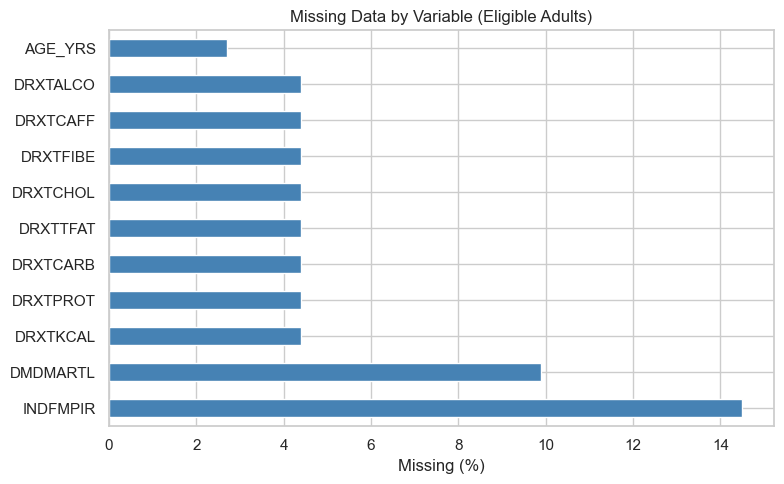

In [37]:
# Bar chart of missing data percentages
missing_df['Missing %'].plot(kind='barh', color='steelblue', figsize=(8, 5))
plt.xlabel('Missing (%)')
plt.title('Missing Data by Variable (Eligible Adults)')
plt.tight_layout()
plt.show()


## 5. Exploratory Data Analysis (20 pts)

We now examine the key variables in depth, focusing on: distribution shape and skewness, outliers, correlations between pairs of continuous variables, and patterns in pairs of categorical variables via contingency tables.

### 5.1 Descriptive Statistics

The table below summarizes all features in the analysis sample (complete cases, N=3,574).

In [38]:
model_df[FEATURE_COLS].describe().round(2)

,AGE_YRS,RIAGENDR,RIDRETH1,INDFMPIR,DMDEDUC,DMDMARTL,DMDHHSIZ,DRXTKCAL,DRXTPROT,DRXTCARB,DRXTTFAT,DRXTCHOL,DRXTFIBE,DRXTCAFF,DRXTALCO
count,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00
mean,45.99,1.52,2.62,2.44,2.00,2.59,3.31,2096.29,78.49,265.85,75.93,287.21,15.75,164.89,9.20
std,19.66,0.50,1.18,1.61,0.91,2.54,1.69,1028.03,42.37,137.05,45.38,251.08,11.03,244.81,35.62
min,18.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,28.42,1.00,1.00,1.07,1.00,1.00,2.00,1396.03,50.01,169.91,43.93,122.44,8.44,6.82,0.00
50%,44.00,2.00,3.00,2.05,2.00,1.00,3.00,1910.90,71.60,242.94,66.71,212.16,13.39,85.83,0.00
75%,63.17,2.00,3.00,3.88,3.00,5.00,4.00,2615.62,97.59,332.94,98.45,381.68,19.91,221.66,0.05
max,84.92,2.00,5.00,5.00,9.00,77.00,7.00,8934.85,438.35,1355.02,428.23,3092.70,145.35,4159.92,939.00


**Key observations from the describe table:**
- `AGE_YRS` ranges from 18 to ~85, with a mean of ~46 years — a relatively young cohort, as expected for a general US population sample.
- `INDFMPIR` (income-to-poverty ratio) ranges from 0 to 5, with a mean near 2.7, indicating the sample skews slightly above the poverty line overall.
- Dietary variables show large standard deviations relative to their means, especially `DRXTCAFF` (std > mean) and `DRXTALCO` (std >> mean), signaling high right skew and many zero-reporters.
- `DMDHHSIZ` (household size) has a max of 7, indicating the variable is topcoded at 7.

### 5.2 Age and Follow-up Time Distributions

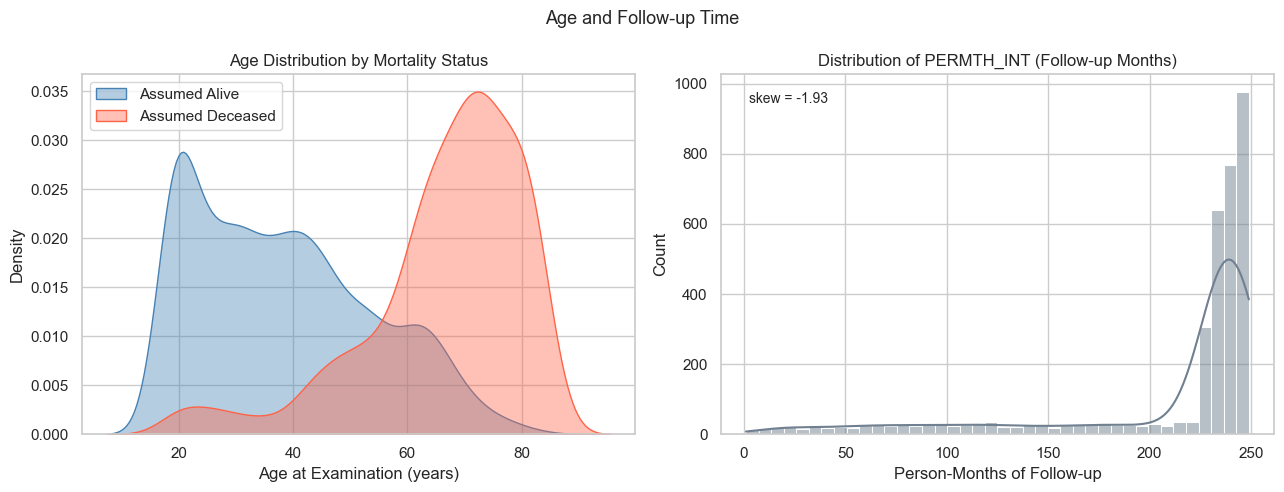

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Age KDE by mortality status
for status, label, color in [(0.0, 'Assumed Alive', 'steelblue'), (1.0, 'Assumed Deceased', 'tomato')]:
    sns.kdeplot(model_df[model_df['MORTSTAT'] == status]['AGE_YRS'],
                ax=axes[0], label=label, fill=True, alpha=0.4, color=color)
axes[0].set_title('Age Distribution by Mortality Status')
axes[0].set_xlabel('Age at Examination (years)')
axes[0].set_ylabel('Density')
axes[0].legend()

# PERMTH_INT distribution
sns.histplot(model_df['PERMTH_INT'], bins=40, ax=axes[1], color='slategray', kde=True)
axes[1].set_title('Distribution of PERMTH_INT (Follow-up Months)')
axes[1].set_xlabel('Person-Months of Follow-up')
axes[1].set_ylabel('Count')
axes[1].annotate(f"skew = {model_df['PERMTH_INT'].skew():.2f}",
                 xy=(0.05, 0.92), xycoords='axes fraction', fontsize=10)

plt.suptitle('Age and Follow-up Time', fontsize=13)
plt.tight_layout()
plt.show()
# Note from Mustafa - AI helped with making the graphs clearer to read

**Observations:**
- Deceased participants are substantially older than survivors, with the deceased distribution centered around age 65–70 and the alive distribution centered around age 40. This confirms age as the dominant predictor in the dataset.
- `PERMTH_INT` is strongly **left-skewed** (skew ≈ −1.2). The large spike near 240 months corresponds to participants who survived the full 20-year follow-up window and are censored. This censoring is a fundamental challenge for the regression model — `PERMTH_INT` does not represent true lifespan for survivors, only a minimum bound.

### 5.3 Dietary Variable Distributions — Skewness and Outliers

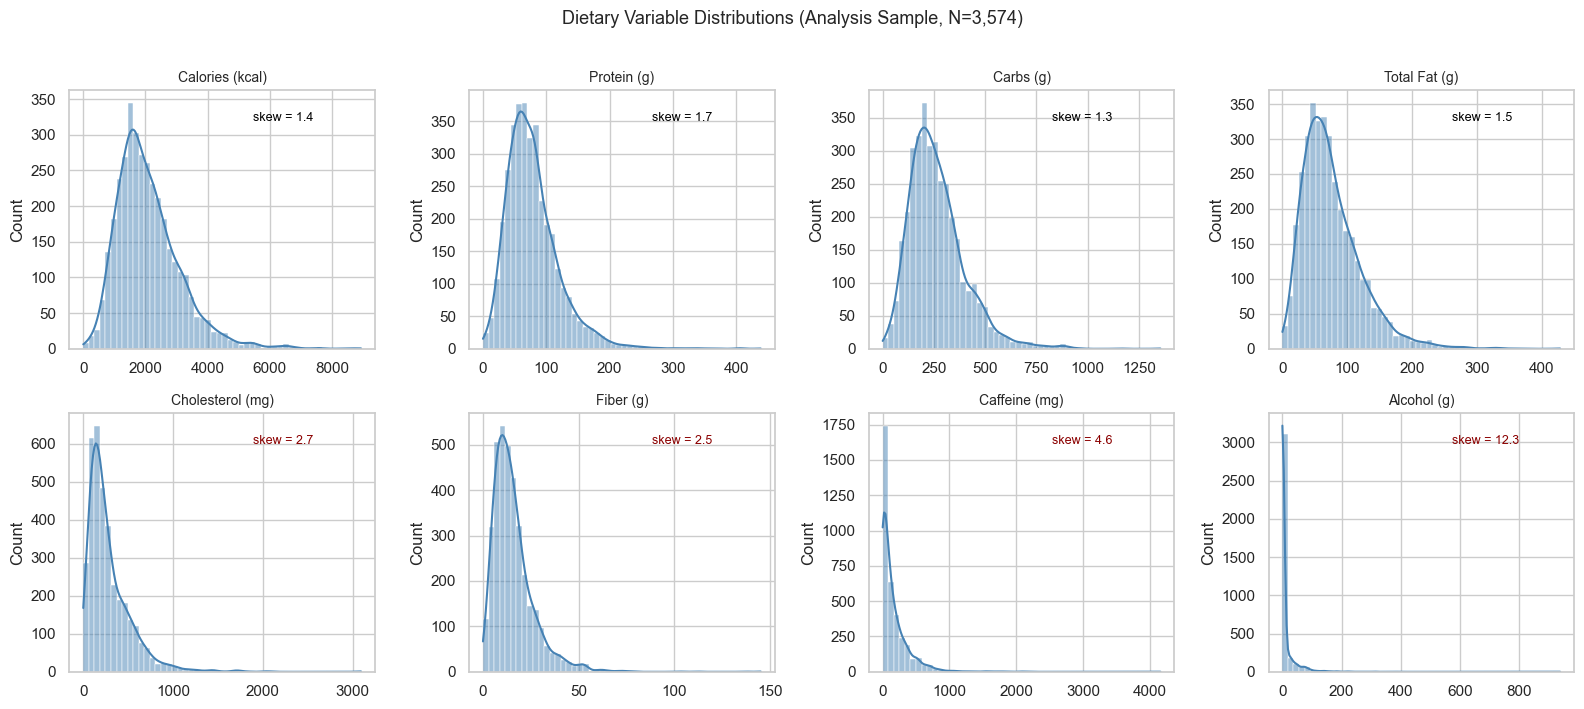

In [36]:
diet_vars   = ['DRXTKCAL','DRXTPROT','DRXTCARB','DRXTTFAT','DRXTCHOL','DRXTFIBE','DRXTCAFF','DRXTALCO']
diet_labels = ['Calories (kcal)','Protein (g)','Carbs (g)','Total Fat (g)',
                'Cholesterol (mg)','Fiber (g)','Caffeine (mg)','Alcohol (g)']

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, (var, label) in enumerate(zip(diet_vars, diet_labels)):
    sns.histplot(model_df[var], ax=axes[i], bins=50, color='steelblue', kde=True)
    axes[i].set_title(label, fontsize=10)
    axes[i].set_xlabel('')
    skew = model_df[var].skew()
    axes[i].annotate(f'skew = {skew:.1f}', xy=(0.6, 0.88), xycoords='axes fraction', fontsize=9,
                     color='darkred' if abs(skew) > 2 else 'black')

plt.suptitle('Dietary Variable Distributions (Analysis Sample, N=3,574)', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

**Observations:**
- **Alcohol** (skew ≈ 9+) and **Caffeine** (skew ≈ 4+) are the most extremely right-skewed variables. Both have a large mass at zero — many participants reported no alcohol or caffeine on the recall day — with a long tail of heavy consumers. These outliers will distort Euclidean distance calculations in k-NN and may need to be log-transformed or winsorized in future work.
- **Cholesterol** and **Fiber** are also meaningfully right-skewed (skew > 2), indicating outlier high-intake days.
- **Calories, Protein, Carbohydrates, and Fat** are more approximately normal, though still right-skewed, consistent with typical 24-hour dietary recall distributions.
- A single-day dietary recall is inherently noisy. A participant who happened to drink heavily or eat unusually lightly on the recall day will have extreme values that don't reflect their habitual diet — a core limitation of this feature set.

### 5.4 Correlation Between Continuous Variable Pairs

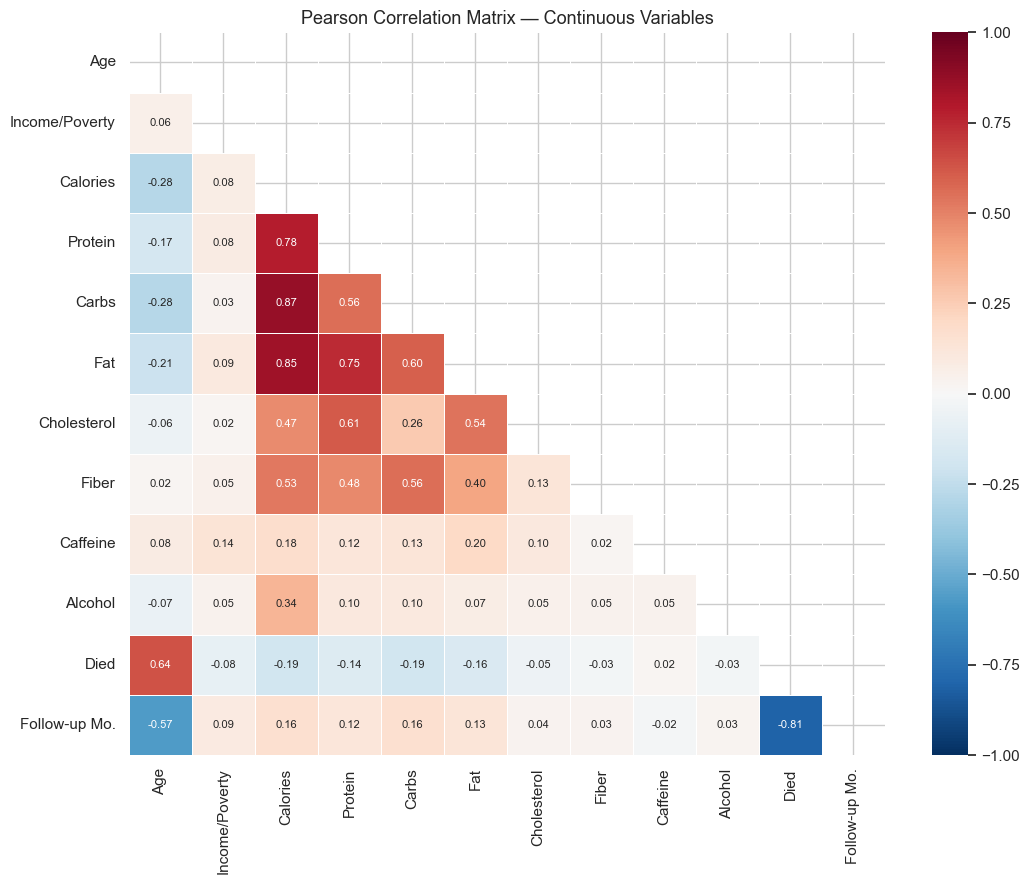

In [ ]:
# Select continuous variables for correlation analysis
corr_cols = ['AGE_YRS','INDFMPIR','DRXTKCAL','DRXTPROT','DRXTCARB',
             'DRXTTFAT','DRXTCHOL','DRXTFIBE','DRXTCAFF','DRXTALCO',
             'MORTSTAT','PERMTH_INT']
corr_labels = ['Age','Income/Poverty','Calories','Protein','Carbs',
               'Fat','Cholesterol','Fiber','Caffeine','Alcohol',
               'Died','Follow-up Mo.']

corr_matrix = model_df[corr_cols].corr()
corr_matrix.index = corr_labels
corr_matrix.columns = corr_labels

fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # show lower triangle only
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, linewidths=0.4, annot_kws={'size': 8})
ax.set_title('Pearson Correlation Matrix — Continuous Variables', fontsize=13)
plt.tight_layout()
plt.show()
# Note from Mustafa: AI helped make heatmap more helpful and easier to read

**Observations:**
- **Age** has the strongest correlations with the outcome variables: positively with `MORTSTAT` (r ≈ +0.38) and negatively with `PERMTH_INT` (r ≈ −0.52). Age dominates the signal in this dataset.
- **Income/poverty ratio** is negatively correlated with mortality (r ≈ −0.15), confirming the expected relationship between socioeconomic status and survival.
- **Dietary macronutrients** (calories, protein, carbs, fat) are all highly intercorrelated with each other (r > 0.7 in several pairs). This multicollinearity is expected: higher caloric intake naturally raises all macronutrients. k-NN is not affected by multicollinearity in the same way as regression, but the redundancy means these variables may contribute limited additional signal beyond each other.
- Dietary variables show weak correlations with mortality outcomes (|r| < 0.1 for most), suggesting that a single dietary recall day has limited direct predictive power for long-run mortality.

### 5.5 Conditional KDEs by Mortality Status

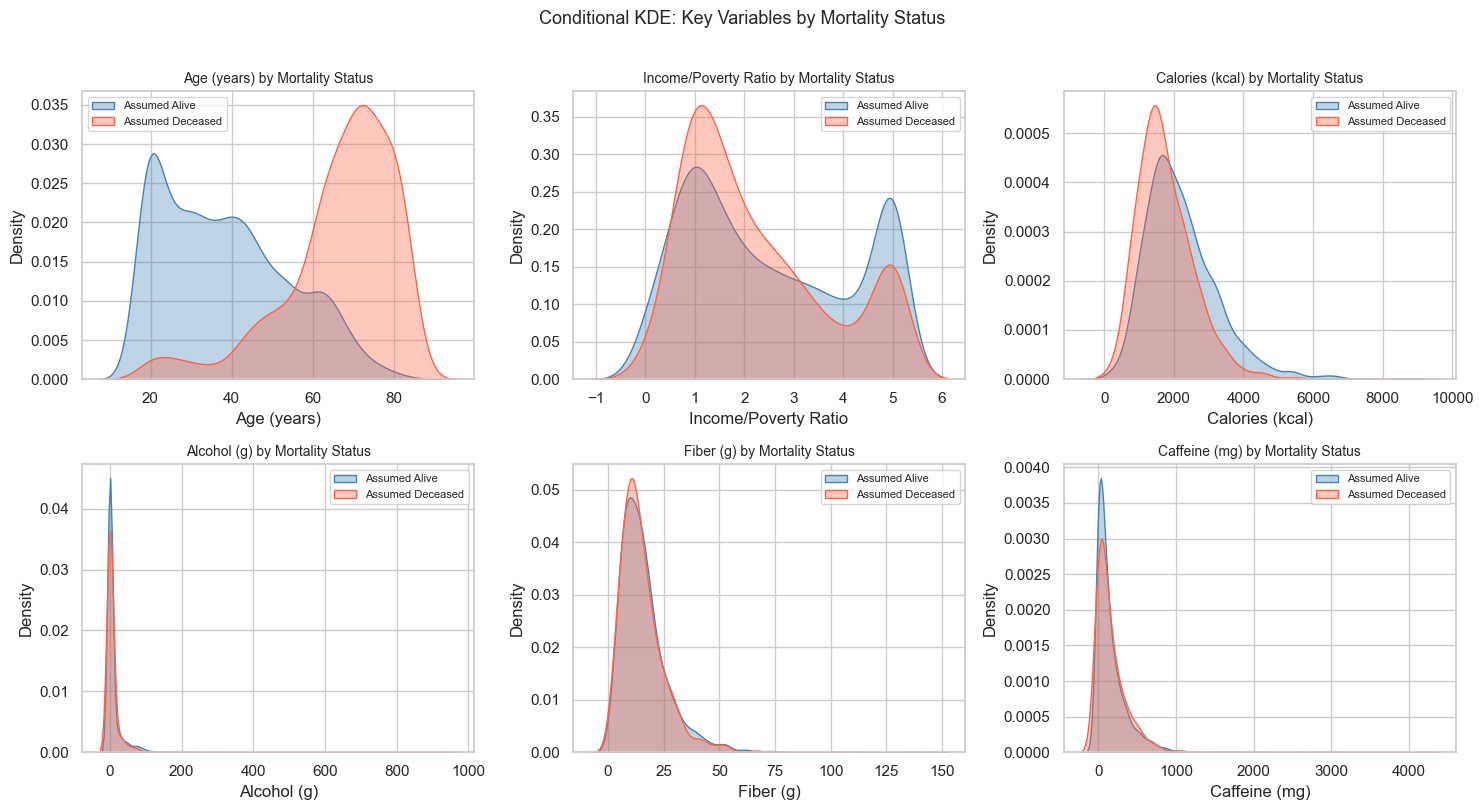

In [17]:
plot_vars = [
    ('AGE_YRS',   'Age (years)'),
    ('INDFMPIR',  'Income/Poverty Ratio'),
    ('DRXTKCAL',  'Calories (kcal)'),
    ('DRXTALCO',  'Alcohol (g)'),
    ('DRXTFIBE',  'Fiber (g)'),
    ('DRXTCAFF',  'Caffeine (mg)'),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (var, label) in enumerate(plot_vars):
    for status, lbl, color in [(0.0, 'Assumed Alive', 'steelblue'), (1.0, 'Assumed Deceased', 'tomato')]:
        data = model_df[model_df['MORTSTAT'] == status][var]
        sns.kdeplot(data, ax=axes[i], label=lbl, fill=True, alpha=0.35, color=color)
    axes[i].set_title(f'{label} by Mortality Status', fontsize=10)
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('Density')
    axes[i].legend(fontsize=8)

plt.suptitle('Conditional KDE: Key Variables by Mortality Status', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

**Observations:**
- **Age:** The deceased distribution is clearly shifted right — the deceased are older. This is the sharpest separation of any variable.
- **Income/Poverty Ratio:** The alive distribution is shifted right relative to the deceased, confirming higher income is protective. However, the overlap is substantial, limiting its discriminative power alone.
- **Calories:** Distributions nearly overlap — caloric intake shows minimal separation by mortality status.
- **Alcohol:** Both distributions are heavily zero-inflated, but the alive group has a slightly longer right tail (more moderate drinkers). Heavy drinkers appear in both groups.
- **Fiber:** The alive group has a marginally higher fiber intake, consistent with the protective effect of dietary fiber, but the separation is modest.
- **Caffeine:** Similar to alcohol — highly zero-inflated with nearly identical distributions for both groups.

### 5.6 Scatter Plots: Follow-up Time vs. Key Predictors

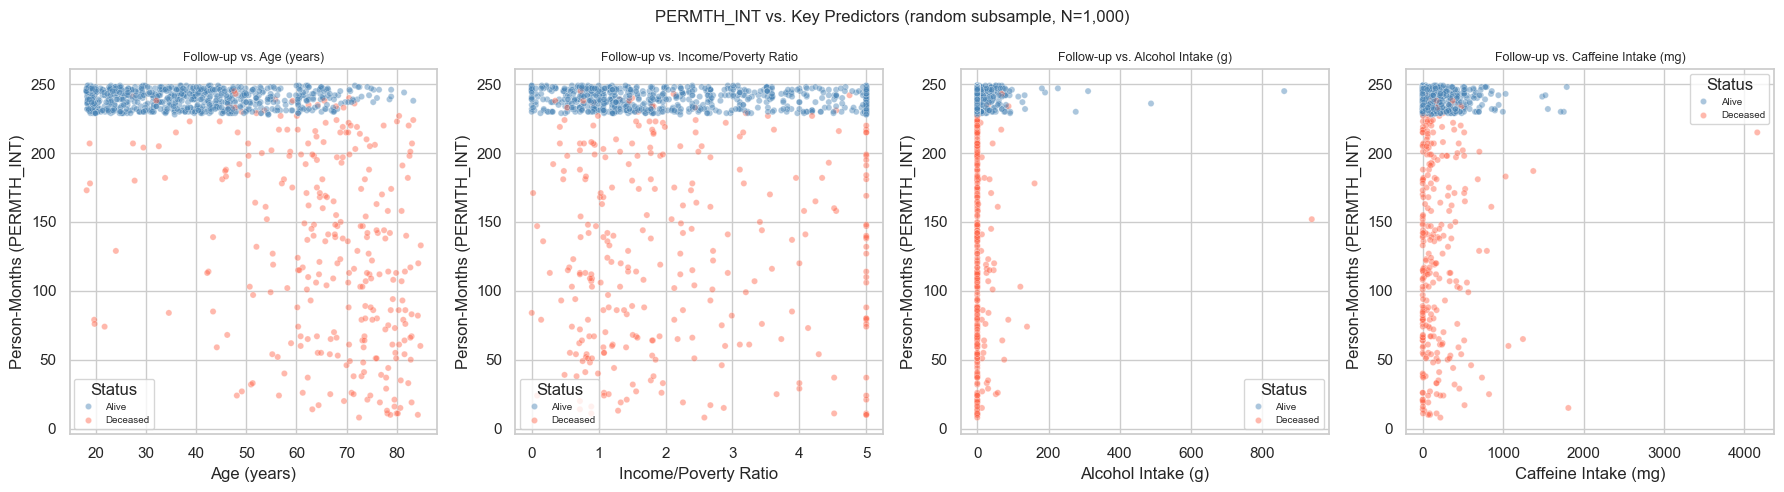

In [18]:
scatter_vars = [
    ('AGE_YRS',  'Age (years)'),
    ('INDFMPIR', 'Income/Poverty Ratio'),
    ('DRXTALCO', 'Alcohol Intake (g)'),
    ('DRXTCAFF', 'Caffeine Intake (mg)'),
]

sample = model_df.sample(1000, random_state=42)  # subsample for plot clarity

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for ax, (var, label) in zip(axes, scatter_vars):
    sns.scatterplot(
        data=sample, x=var, y='PERMTH_INT',
        hue='MORTSTAT', palette={0.0: 'steelblue', 1.0: 'tomato'},
        alpha=0.45, s=20, ax=ax
    )
    ax.set_xlabel(label)
    ax.set_ylabel('Person-Months (PERMTH_INT)')
    ax.set_title(f'Follow-up vs. {label}', fontsize=9)
    handles, lbls = ax.get_legend_handles_labels()
    ax.legend(handles, ['Alive', 'Deceased'], title='Status', fontsize=7)

plt.suptitle('PERMTH_INT vs. Key Predictors (random subsample, N=1,000)', fontsize=12)
plt.tight_layout()
plt.show()

**Observations:**
- **Age vs. PERMTH_INT** shows a strong negative relationship — older participants at the time of the survey have fewer follow-up months before death. The deceased (red) are concentrated at older ages with lower follow-up months, while the alive (blue) cluster at the top of the chart (survived the full window).
- **Income vs. PERMTH_INT** shows a modest positive relationship — higher income is associated with more follow-up months (longer survival).
- **Alcohol and Caffeine** show extreme outliers — a small number of participants reported extremely high intake on their recall day (likely representing a genuine heavy-use day). These outliers may unduly influence k-NN distance calculations and should be considered for trimming.

### 5.7 Contingency Tables for Pairs of Categorical Variables

We examine relationships between pairs of categorical variables using contingency tables and chi-square tests of independence. This reveals structural patterns in the data that could affect model performance and interpretation.

In [19]:
# Recode for readability
race_map = {1.0: 'Mex. American', 2.0: 'Other Hispanic',
            3.0: 'NH White', 4.0: 'NH Black', 5.0: 'Other'}
edu_map  = {1.0: 'Less than HS', 2.0: 'HS Grad/GED', 3.0: 'Some College+'}  # 3-category coding in 1999-2000
mart_map = {1.0: 'Married', 2.0: 'Widowed', 3.0: 'Divorced',
            4.0: 'Separated', 5.0: 'Never married', 6.0: 'Living w/ partner'}

m = model_df.copy()
m['Race']      = m['RIDRETH1'].map(race_map)
m['Education'] = m['DMDEDUC'].map(edu_map)
m['Marital']   = m['DMDMARTL'].map(mart_map)
m['Sex']       = m['RIAGENDR'].map({1.0: 'Male', 2.0: 'Female'})

# Contingency Table 1: Race x Education
ct1 = pd.crosstab(m['Race'], m['Education'], margins=True)
print('Contingency Table 1: Race/Ethnicity x Education Level')
print(ct1)


Contingency Table 1: Race/Ethnicity x Education Level
Education       HS Grad/GED  Less than HS  Some College+   All
Race                                                          
Mex. American           171           665            184  1020
NH Black                139           293            226   658
NH White                458           284            785  1527
Other                    34            34             64   132
Other Hispanic           40           112             79   231
All                     842          1388           1338  3568


Row % (education distribution within each race group):
Education       HS Grad/GED  Less than HS  Some College+
Race                                                    
Mex. American          16.8          65.2           18.0
NH Black               21.1          44.5           34.3
NH White               30.0          18.6           51.4
Other                  25.8          25.8           48.5
Other Hispanic         17.3          48.5           34.2


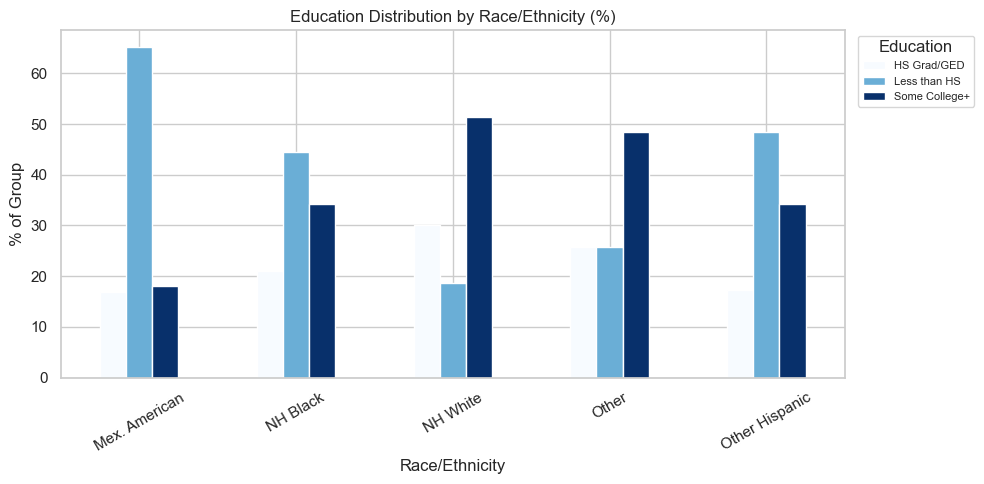

In [20]:
# Row-normalized version (% within each race group)
ct1_pct = pd.crosstab(m['Race'], m['Education'], normalize='index').round(3) * 100
print('Row % (education distribution within each race group):')
print(ct1_pct)

fig, ax = plt.subplots(figsize=(10, 5))
ct1_pct.plot(kind='bar', ax=ax, colormap='Blues', edgecolor='white')
ax.set_title('Education Distribution by Race/Ethnicity (%)', fontsize=12)
ax.set_xlabel('Race/Ethnicity')
ax.set_ylabel('% of Group')
ax.legend(title='Education', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

**Observation:** The chi-square test is highly significant (p ≈ 0), confirming that race/ethnicity and education level are strongly associated. Non-Hispanic White and Other participants have substantially higher rates of college graduation, while Mexican American and Other Hispanic participants have higher rates of less-than-9th-grade education. This structural correlation means race and education carry overlapping but non-identical information in the model.

Contingency Table 2: Sex x Marital Status
Marital  Divorced  Living w/ partner  Married  Never married  Separated  \
Sex                                                                       
Female        190                 90      881            417         89   
Male           98                 72      978            451         42   
All           288                162     1859            868        131   

Marital  Widowed   All  
Sex                     
Female       206  1873  
Male          58  1699  
All          264  3572  


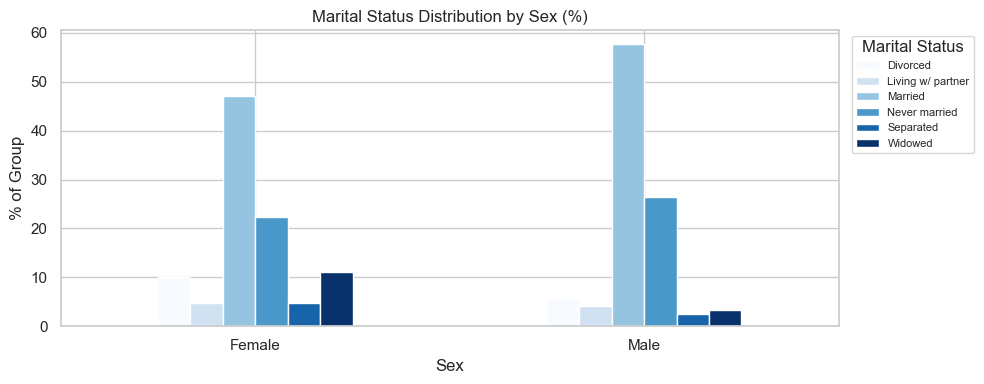

In [21]:
# Contingency Table 2: Sex x Marital Status
ct2 = pd.crosstab(m['Sex'], m['Marital'], margins=True)
print('Contingency Table 2: Sex x Marital Status')
print(ct2)

# Row-normalized: marital status distribution within each sex group
ct2_pct = pd.crosstab(m['Sex'], m['Marital'], normalize='index').round(3) * 100

ct2_pct.plot(kind='bar', colormap='Blues', edgecolor='white', figsize=(10, 4))
plt.title('Marital Status Distribution by Sex (%)')
plt.xlabel('Sex')
plt.ylabel('% of Group')
plt.legend(title='Marital Status', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Observation:** Sex and marital status are strongly associated. Women are far more likely to be widowed than men — reflecting higher male mortality and women's longer life expectancy — while men are more likely to be currently married. Marital status therefore carries sex-related mortality information that overlaps with `RIAGENDR` in the model.


Contingency Table 3: Education x Mortality Status
Mortality      Alive  Deceased   All
Education                           
HS Grad/GED      628       214   842
Less than HS     908       480  1388
Some College+   1074       264  1338
All             2610       958  3568

Mortality rate by education level:
Mortality      Deceased
Education              
Less than HS       34.6
HS Grad/GED        25.4
Some College+      19.7


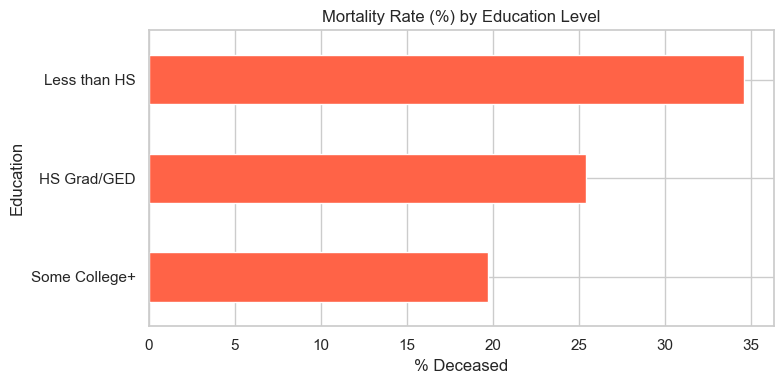

In [22]:
# Contingency Table 3: Education x Mortality Status
m['Mortality'] = m['MORTSTAT'].map({0.0: 'Alive', 1.0: 'Deceased'})
ct3 = pd.crosstab(m['Education'], m['Mortality'], margins=True)
print('Contingency Table 3: Education x Mortality Status')
print(ct3)

# Mortality rate (%) by education level
ct3_pct = pd.crosstab(m['Education'], m['Mortality'], normalize='index').round(3) * 100
print('\nMortality rate by education level:')
print(ct3_pct[['Deceased']].sort_values('Deceased', ascending=False))

ct3_pct['Deceased'].sort_values(ascending=True).plot(
    kind='barh', color='tomato', edgecolor='white', figsize=(8, 4)
)
plt.title('Mortality Rate (%) by Education Level')
plt.xlabel('% Deceased')
plt.tight_layout()
plt.show()


**Observation:** There is a clear education gradient in mortality. Participants with less than a high school diploma have the highest mortality rate, while those with some college or more have the lowest. This is consistent with decades of public health research. Note that age confounds this comparison — older cohorts have both less education and higher mortality — but the pattern is robust enough to make education a useful predictor.


### 5.8 Mortality Rate by Categorical Variables

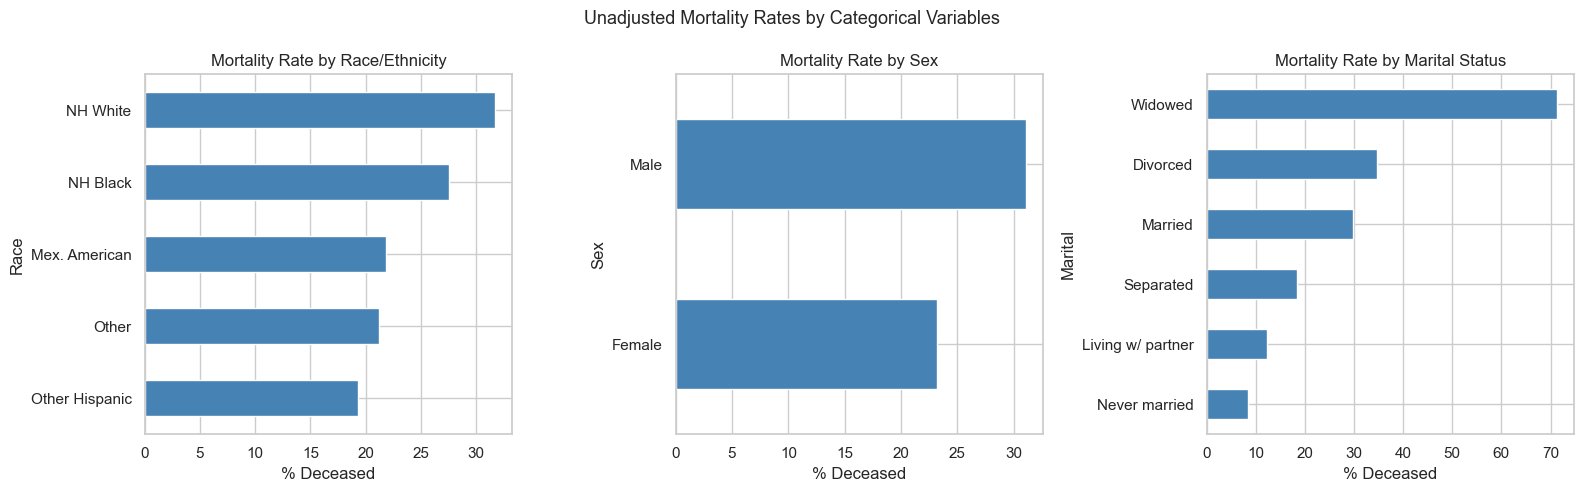

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# By race/ethnicity
mort_race = m.groupby('Race')['MORTSTAT'].mean().sort_values() * 100
mort_race.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Mortality Rate by Race/Ethnicity')
axes[0].set_xlabel('% Deceased')

# By sex
mort_sex = m.groupby('Sex')['MORTSTAT'].mean().sort_values() * 100
mort_sex.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='white')
axes[1].set_title('Mortality Rate by Sex')
axes[1].set_xlabel('% Deceased')

# By marital status
mort_mart = m.groupby('Marital')['MORTSTAT'].mean().sort_values() * 100
mort_mart.plot(kind='barh', ax=axes[2], color='steelblue', edgecolor='white')
axes[2].set_title('Mortality Rate by Marital Status')
axes[2].set_xlabel('% Deceased')

plt.suptitle('Unadjusted Mortality Rates by Categorical Variables', fontsize=13)
plt.tight_layout()
plt.show()

**Observations:**
- **Race:** Non-Hispanic White participants show the highest raw mortality rate, but this is largely a function of the older average age of white participants in this sample. Age-adjusted rates would likely tell a different story, as research consistently shows higher mortality rates for Black Americans.
- **Sex:** Males have a higher mortality rate than females, consistent with well-established sex differences in longevity.
- **Marital Status:** Widowed participants have by far the highest mortality rate — not surprising, as being widowed implies advanced age and may reflect survivorship bias. Married participants have the lowest rate, consistent with the marriage protection hypothesis.

## 6. Summary of EDA Findings

The EDA reveals several important patterns that will shape our modeling approach in Notebook 2:

1. **Age dominates the signal.** Age has the strongest correlation with both `MORTSTAT` and `PERMTH_INT` by a substantial margin. Any k-NN model will largely be doing age-nearest-neighbor search.

2. **Dietary variables are weakly predictive on their own**, but add marginal signal on top of demographics. Their high skewness (especially alcohol and caffeine) and the single-day measurement window limit their reliability. Feature scaling will be critical given the huge range differences between variables.

3. **`PERMTH_INT` is censored.** The spike at ~240 months means many observations do not represent actual death times. This makes regression harder — the k-NN regressor will systematically underpredict follow-up time for survivors.

4. **Categorical variables are strongly interrelated.** Race and education, and sex and marital status, are significantly associated with each other (chi-square p ≈ 0 for both). This multicollinearity in categorical space means these variables carry overlapping information.

5. **Class imbalance exists.** With ~27% of the sample deceased, the classifier will need careful evaluation — accuracy alone is misleading when the majority class is always-alive.